<a href="https://colab.research.google.com/github/samyaknd/movie-revenue-prediction/blob/main/movie_revenue_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize


### 1. Data Loading and Cleanup

I take look at columns that have significant amount of missing values

Also, In the dataset I saw that a few of the columns are JSON like strings, so I converted them to dictionaries so that they are easier to work with.

In [3]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

print(test.shape)
print(train.shape)
train.info()


(4398, 22)
(3000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-nu

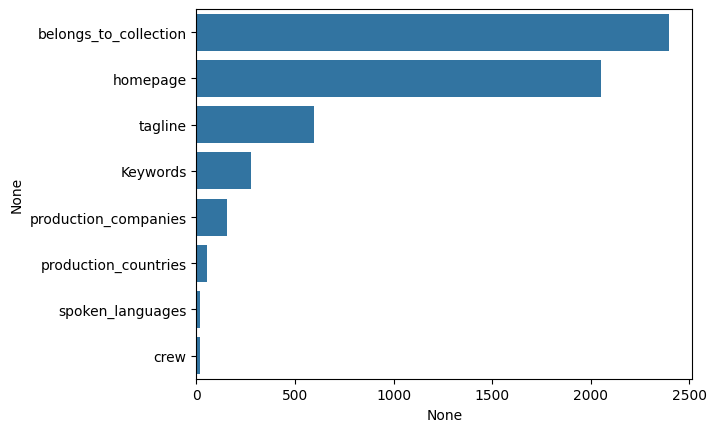

In [4]:
missing = train.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:8],y=missing[:8].index)
plt.show()

In [5]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def safe_literal_eval(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        elif isinstance(val, (dict, list)):
            return val
        else:
            return {}
    except (ValueError, SyntaxError):
        return {}

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if x is None else safe_literal_eval(x))
    return df

print("Before transformation types:")
print(train['belongs_to_collection'].apply(type).head())

dfx = text_to_dict(train)
for col in dict_columns:
    train[col] = dfx[col]

print("After transformation types:")
print(train['belongs_to_collection'].apply(type).head())


Before transformation types:
0      <class 'str'>
1      <class 'str'>
2    <class 'float'>
3    <class 'float'>
4    <class 'float'>
Name: belongs_to_collection, dtype: object
After transformation types:
0    <class 'list'>
1    <class 'list'>
2    <class 'dict'>
3    <class 'dict'>
4    <class 'dict'>
Name: belongs_to_collection, dtype: object


In [6]:
dfx = text_to_dict(test)
for col in dict_columns:
    test[col] = dfx[col]

#### EDA Part 1:

I am going to do EDA on the following columns:

**belongs_to_collection:** Understanding the distribution and frequency of movie collections can reveal insights into the prevalence of franchises within the dataset, offering valuable information for analyzing patterns in movie success and audience engagement.

**tagline:** Examining the presence of taglines across movies allows for an understanding of how frequently movies utilize taglines as part of their marketing strategies, shedding light on their potential impact on audience perception and box office performance.

**keywords:** Investigating the most frequent and significant keywords within the movie dataset enables the identification of recurring themes and topics across films, providing valuable insights into audience interests and potential genre trends.

**production_companies:** Analyzing production companies' involvement in movie production offers insights into industry dynamics, highlighting the most active players and potential associations between production companies and specific movie genres or themes.

**production_countries:** Exploring production countries reveals global film industry trends, showcasing the dominance of key markets like Hollywood and identifying emerging film industries. It also reflects cultural influences, aids in localization strategies, and promotes diversity in filmmaking through international collaborations.

**spoken_languages:** Examining spoken languages in movies provides insights into audience demographics and preferences, aiding in localization efforts and marketing strategies tailored to specific language-speaking regions. It also reflects cultural diversity in filmmaking and highlights opportunities for language-specific content creation.

**genres:** Understanding the distribution of movie genres allows for insights into audience preferences and trends, aiding in content strategy and marketing decisions. It also provides context for analyzing the success and popularity of different genres within the movie dataset.

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


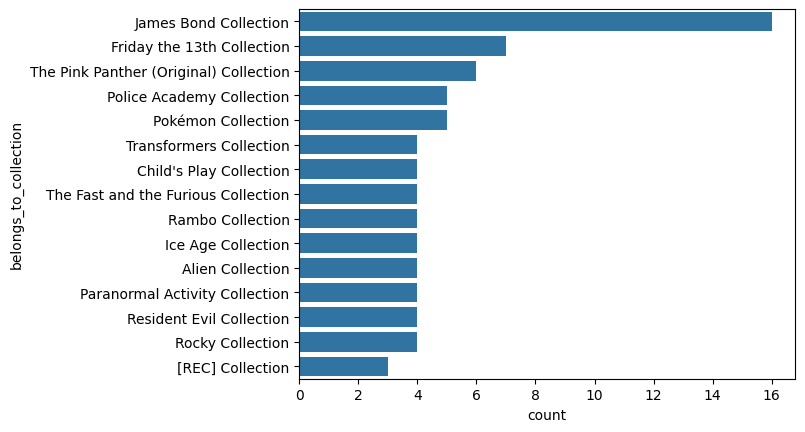

In [7]:
collections_count = train['belongs_to_collection'].apply(lambda x: len(x) if x else 0).value_counts()
print(collections_count)

top_collections = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x else None).value_counts()[0:15]
sns.barplot(x=top_collections, y=top_collections.index)
plt.show()

tagline
1    2403
0     597
Name: count, dtype: int64


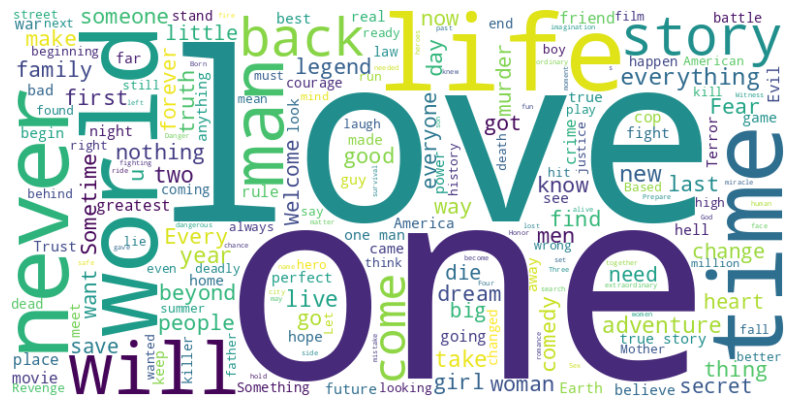

In [8]:
tagline_presence = train['tagline'].notna().astype(int).value_counts()
print(tagline_presence)

plt.figure(figsize=(10, 10))
all_taglines = ' '.join(train['tagline'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_taglines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

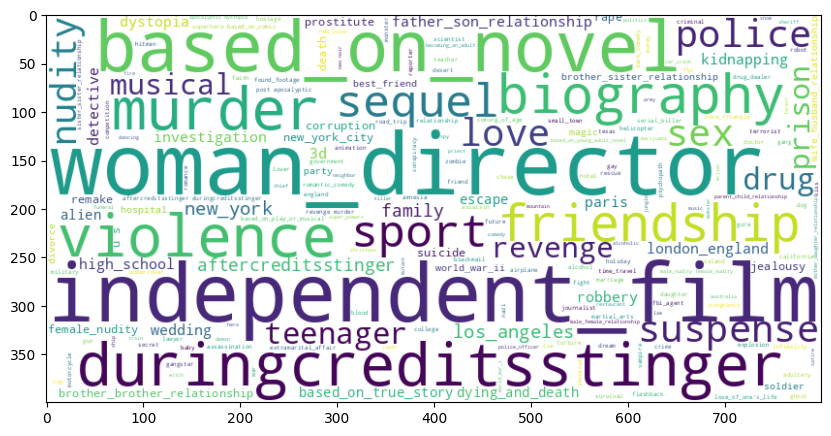

In [9]:
def extract_keywords(keywords):
  return [kw['name'] for kw in keywords] if isinstance(keywords, list) else []

list_of_keywords = train['Keywords'].apply(extract_keywords).tolist()
text = ' '.join('_'.join(kw.split()) for kws in list_of_keywords for kw in kws)

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [10]:
# def extract_country_names(countries):
#   return [country['name'] for country in countries] if isinstance(countries, list) else []

# country_names = train['production_countries'].apply(extract_country_names).tolist()

# country_count = Counter([name for sublist in country_names for name in sublist]).most_common(10)

# sns.barplot(x=[val[1] for val in country_count], y=[val[0] for val in country_count])
# plt.show()

# Here, I have written an abstraction for the above function so that I can resue it for different features

def extract_names(data, column_name, name_key):
    return [item[name_key] for sublist in data[column_name] for item in sublist] if isinstance(data[column_name].iloc[0], list) else []

def plot_most_common(data, column_name, name_key, top_n=10):
    names = extract_names(data, column_name, name_key)
    name_count = Counter(names).most_common(top_n)

    sns.barplot(x=[val[1] for val in name_count], y=[val[0] for val in name_count])
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Top {top_n} Most Common {column_name.capitalize()}')
    plt.show()

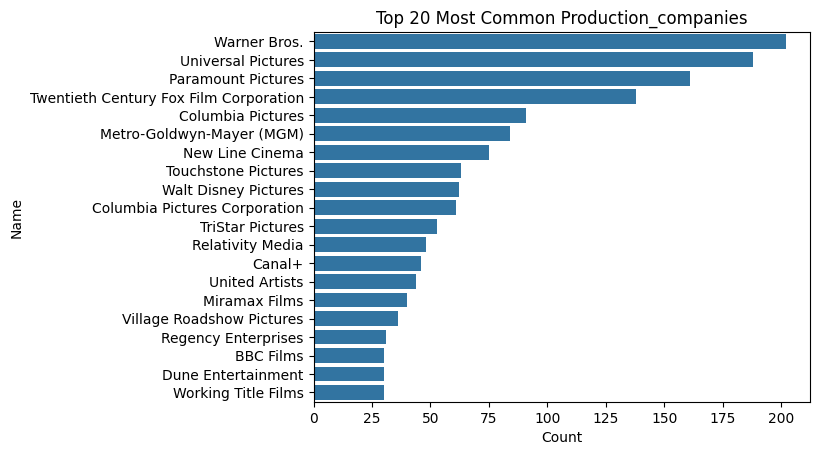

In [11]:
plot_most_common(train, 'production_companies', 'name', top_n=20)

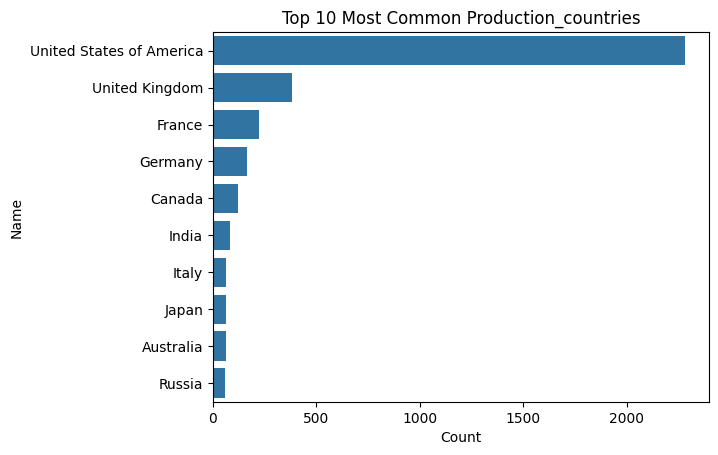

In [12]:
plot_most_common(train, 'production_countries', 'name', top_n=10)

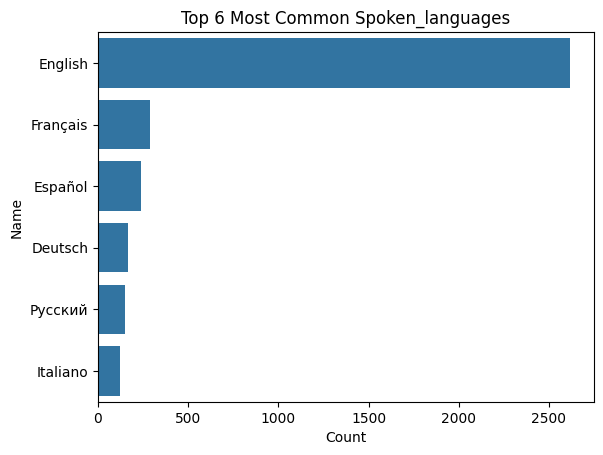

In [13]:
plot_most_common(train, 'spoken_languages', 'name', top_n=6)

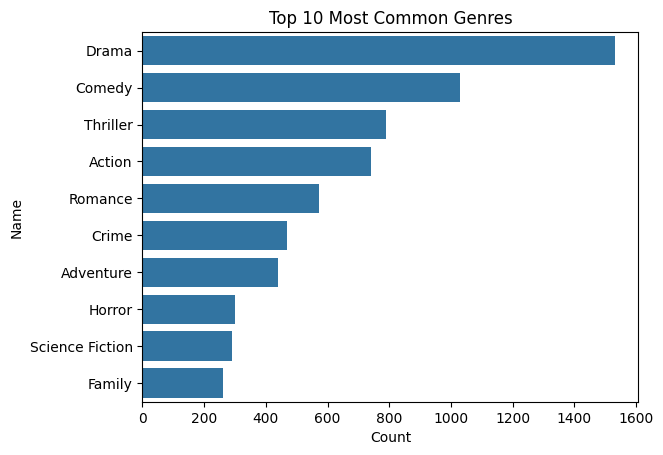

In [14]:
plot_most_common(train, 'genres', 'name', top_n=10)

### EDA Part 2:

Here I will do analysis on the features and their relation to the target variable revenue.

**Log Transformation of Revenue and Budget:**
Log-transforming the revenue and budget variables helps in dealing with skewness and visualizing potential non-linear relationships.

**Budget vs. Revenue:** By plotting budget against revenue, I can observe the correlation between movie budgets and revenues.

**Popularity vs. Revenue:** This plot helps me understand whether more popular movies tend to generate higher revenues.

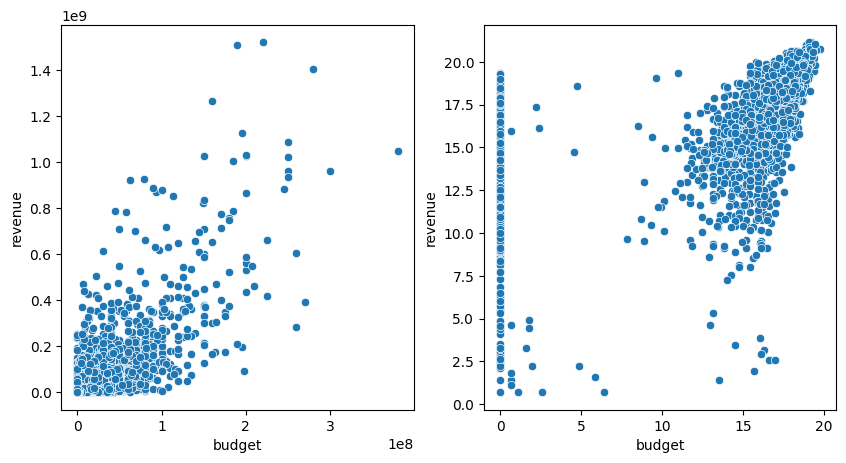

In [15]:
train['log_revenue'] = np.log1p(train['revenue'])
train['log_budget'] = np.log1p(train['budget'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'],y=train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train['budget']),y=np.log1p(train['revenue']))
plt.show()

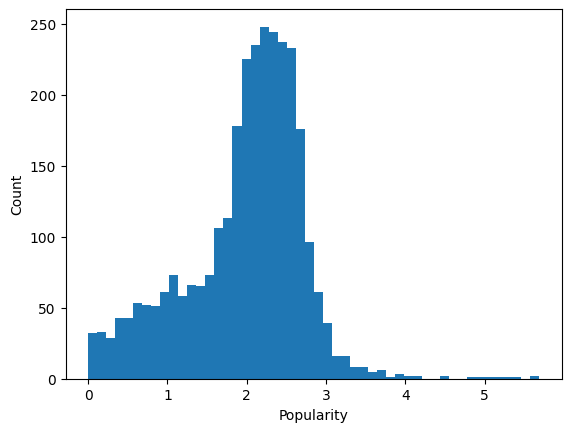

In [16]:
plt.hist(np.log1p(train['popularity']), bins=50)
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

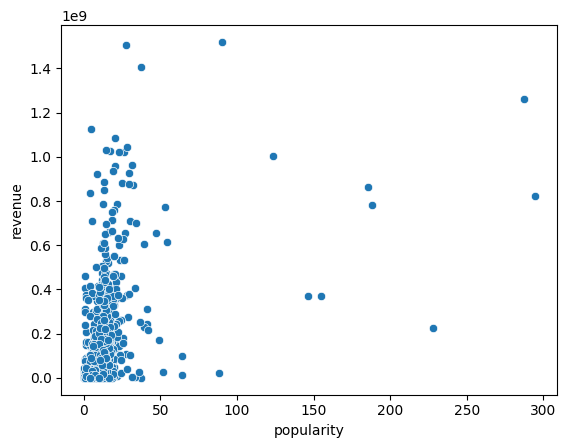

In [17]:
sns.scatterplot(x=train['popularity'],y=train['revenue'])
plt.show()

### EDA Part 3

Performing Exploratory Data Analysis (EDA) on date-related features is crucial as it helps uncover temporal patterns and trends that influence movie performance, such as seasonal peaks or day-of-week preferences for releases. Understanding these patterns can guide the prediction of movie revenue by identifying optimal release times and periods of high competition. Additionally, EDA on date features allows for the identification and correction of data anomalies, ensuring the accuracy and reliability of subsequent analyses and models.

<ipython-input-18-52eb5708bd4c>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation='vertical')


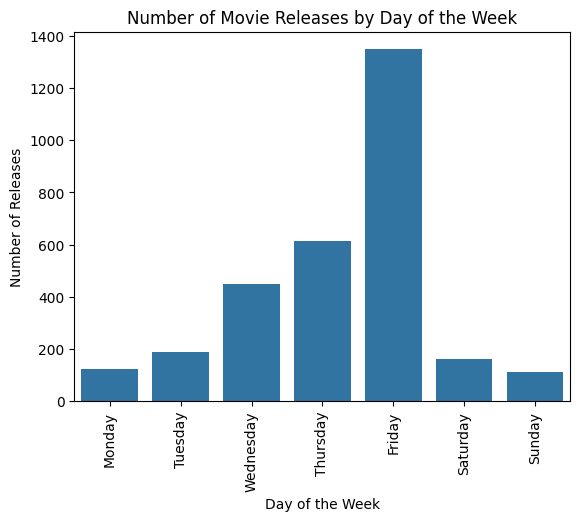

In [18]:
def date(x):
    x = str(x)
    try:
        year = x.split('/')[2]
        if int(year) < 19:
            return x[:-2] + '20' + year
        else:
            return x[:-2] + '19' + year
    except IndexError:
        return '1/1/1990'

train['release_date'] = train['release_date'].fillna('1/1/90')
test['release_date'] = test['release_date'].fillna('1/1/90')

train['release_date'] = train['release_date'].apply(lambda x: date(x))
test['release_date'] = test['release_date'].apply(lambda x: date(x))

train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%Y', errors='coerce')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%Y', errors='coerce')

train['release_day'] = train['release_date'].apply(lambda x: x.weekday() if pd.notnull(x) else -1)
train['release_month'] = train['release_date'].apply(lambda x: x.month if pd.notnull(x) else -1)
train['release_year'] = train['release_date'].apply(lambda x: x.year if pd.notnull(x) else -1)

test['release_day'] = test['release_date'].apply(lambda x: x.weekday() if pd.notnull(x) else -1)
test['release_month'] = test['release_date'].apply(lambda x: x.month if pd.notnull(x) else -1)
test['release_year'] = test['release_date'].apply(lambda x: x.year if pd.notnull(x) else -1)

day = train['release_day'].value_counts().sort_index()
sns.barplot(x=day.index, y=day)
plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation='vertical')
plt.ylabel('Number of Releases')
plt.xlabel('Day of the Week')
plt.title('Number of Movie Releases by Day of the Week')
plt.show()

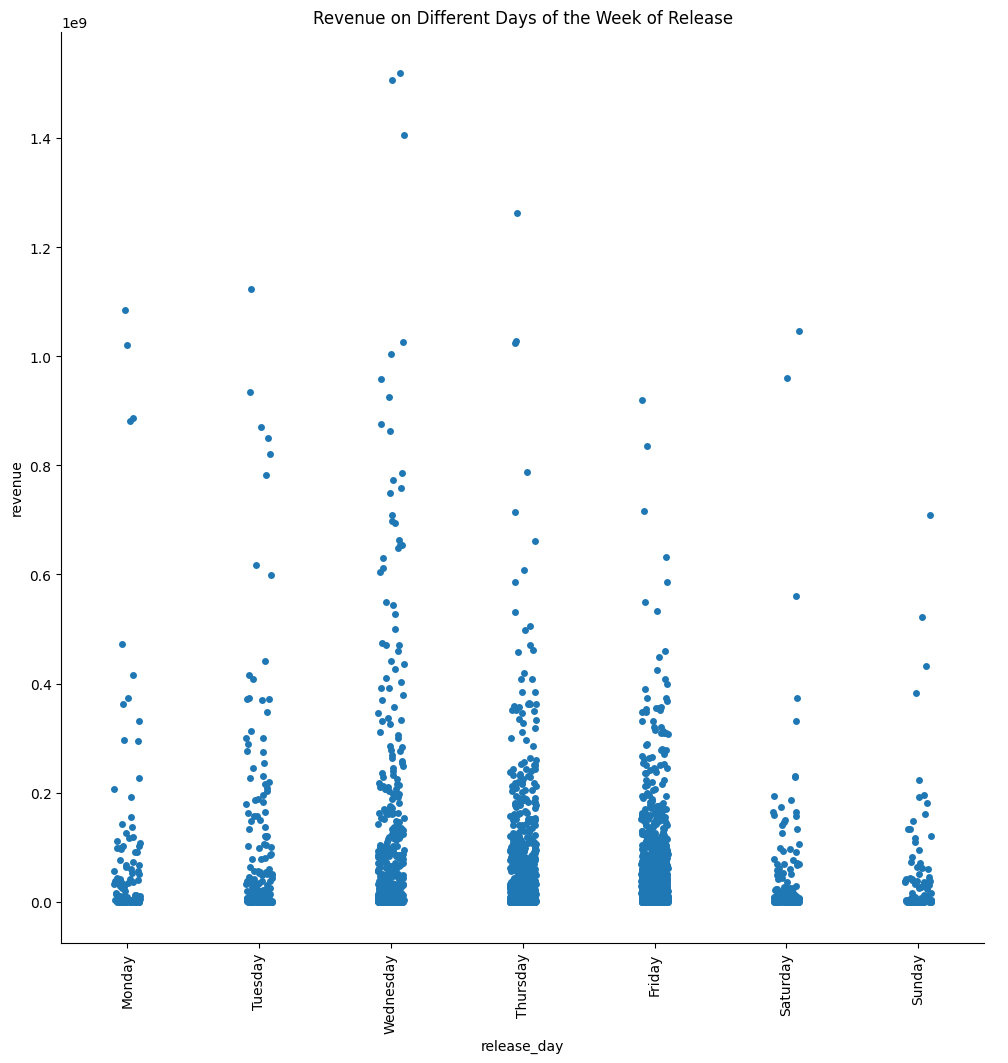

In [20]:
plot = sns.catplot(x='release_day', y='revenue', data=train, height=10, aspect=1)
plot.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)
plt.title('Revenue on Different Days of the Week of Release')
plt.show()


<ipython-input-22-8e45d153ac4d>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)


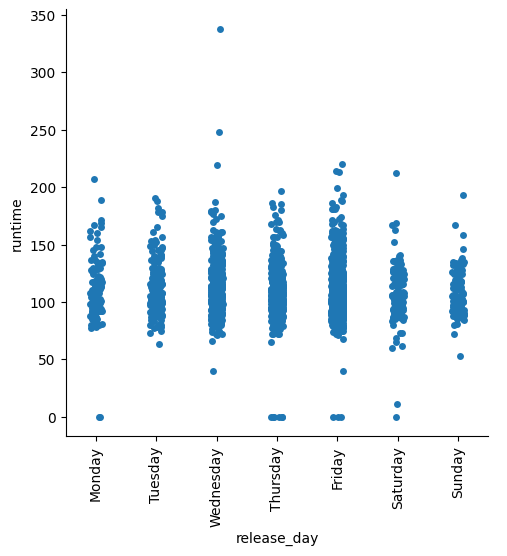

In [22]:
g = sns.catplot(x='release_day', y='runtime', data=train)
for ax in g.axes.flat:
    ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)
plt.show()

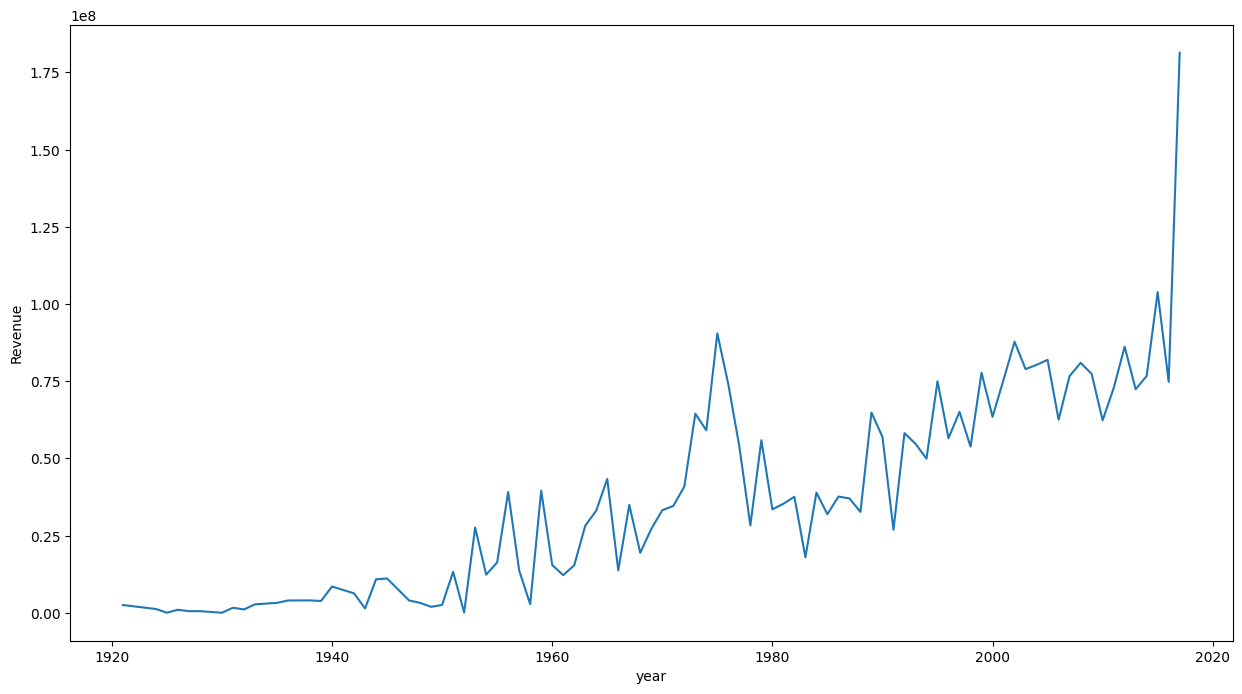

In [23]:
plt.figure(figsize=(15,8))
yearly=train.groupby(train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

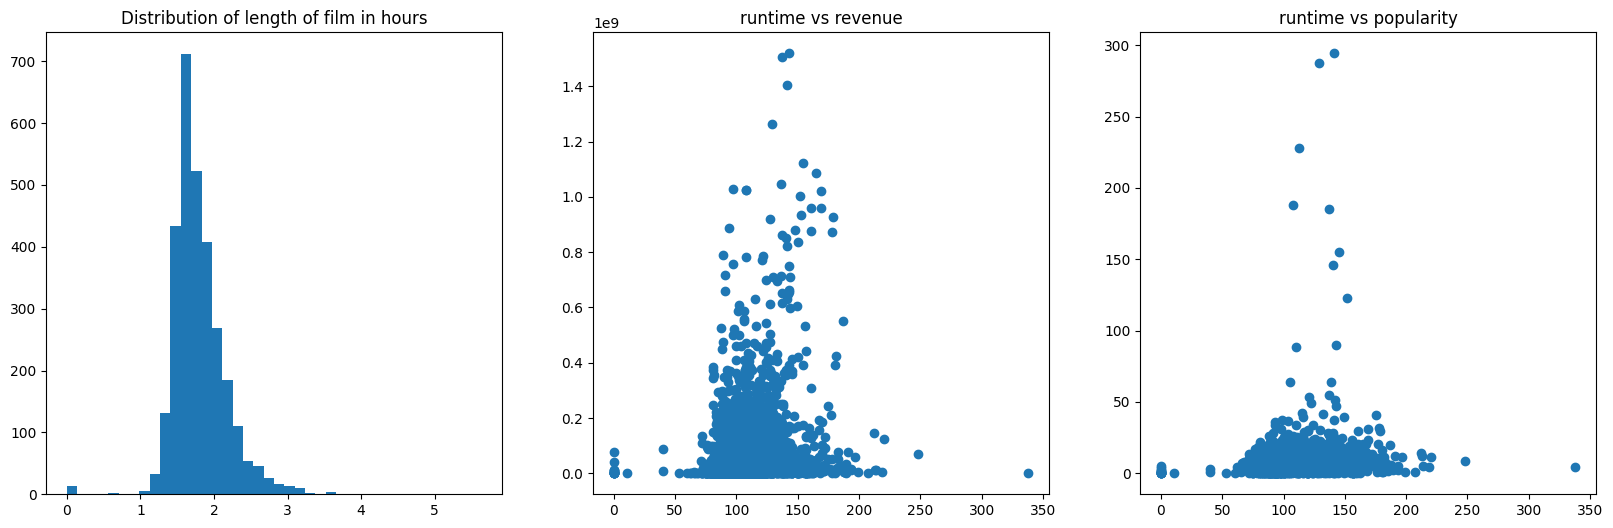

In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

So, above I started by transforming the release dates to ensure correct century formatting, assuming years less than 19 are from the 21st century and those 19 or greater are from the 20th century. I filled missing release dates with '1/1/90' and converted them to datetime format. I then extracted day, month, and year components from the release dates, setting missing values to -1. Visualizing the number of releases by day of the week helped me understand distribution patterns, while analyzing revenue by day of the week revealed potential optimal release days for maximizing revenue. I also explored runtime by release day to identify trends in movie lengths. Observing the average revenue trend over the years highlighted industry changes and audience preferences. Finally, I analyzed the distribution of movie runtimes and their correlation with revenue and popularity, providing insights into factors influencing a movie's success.

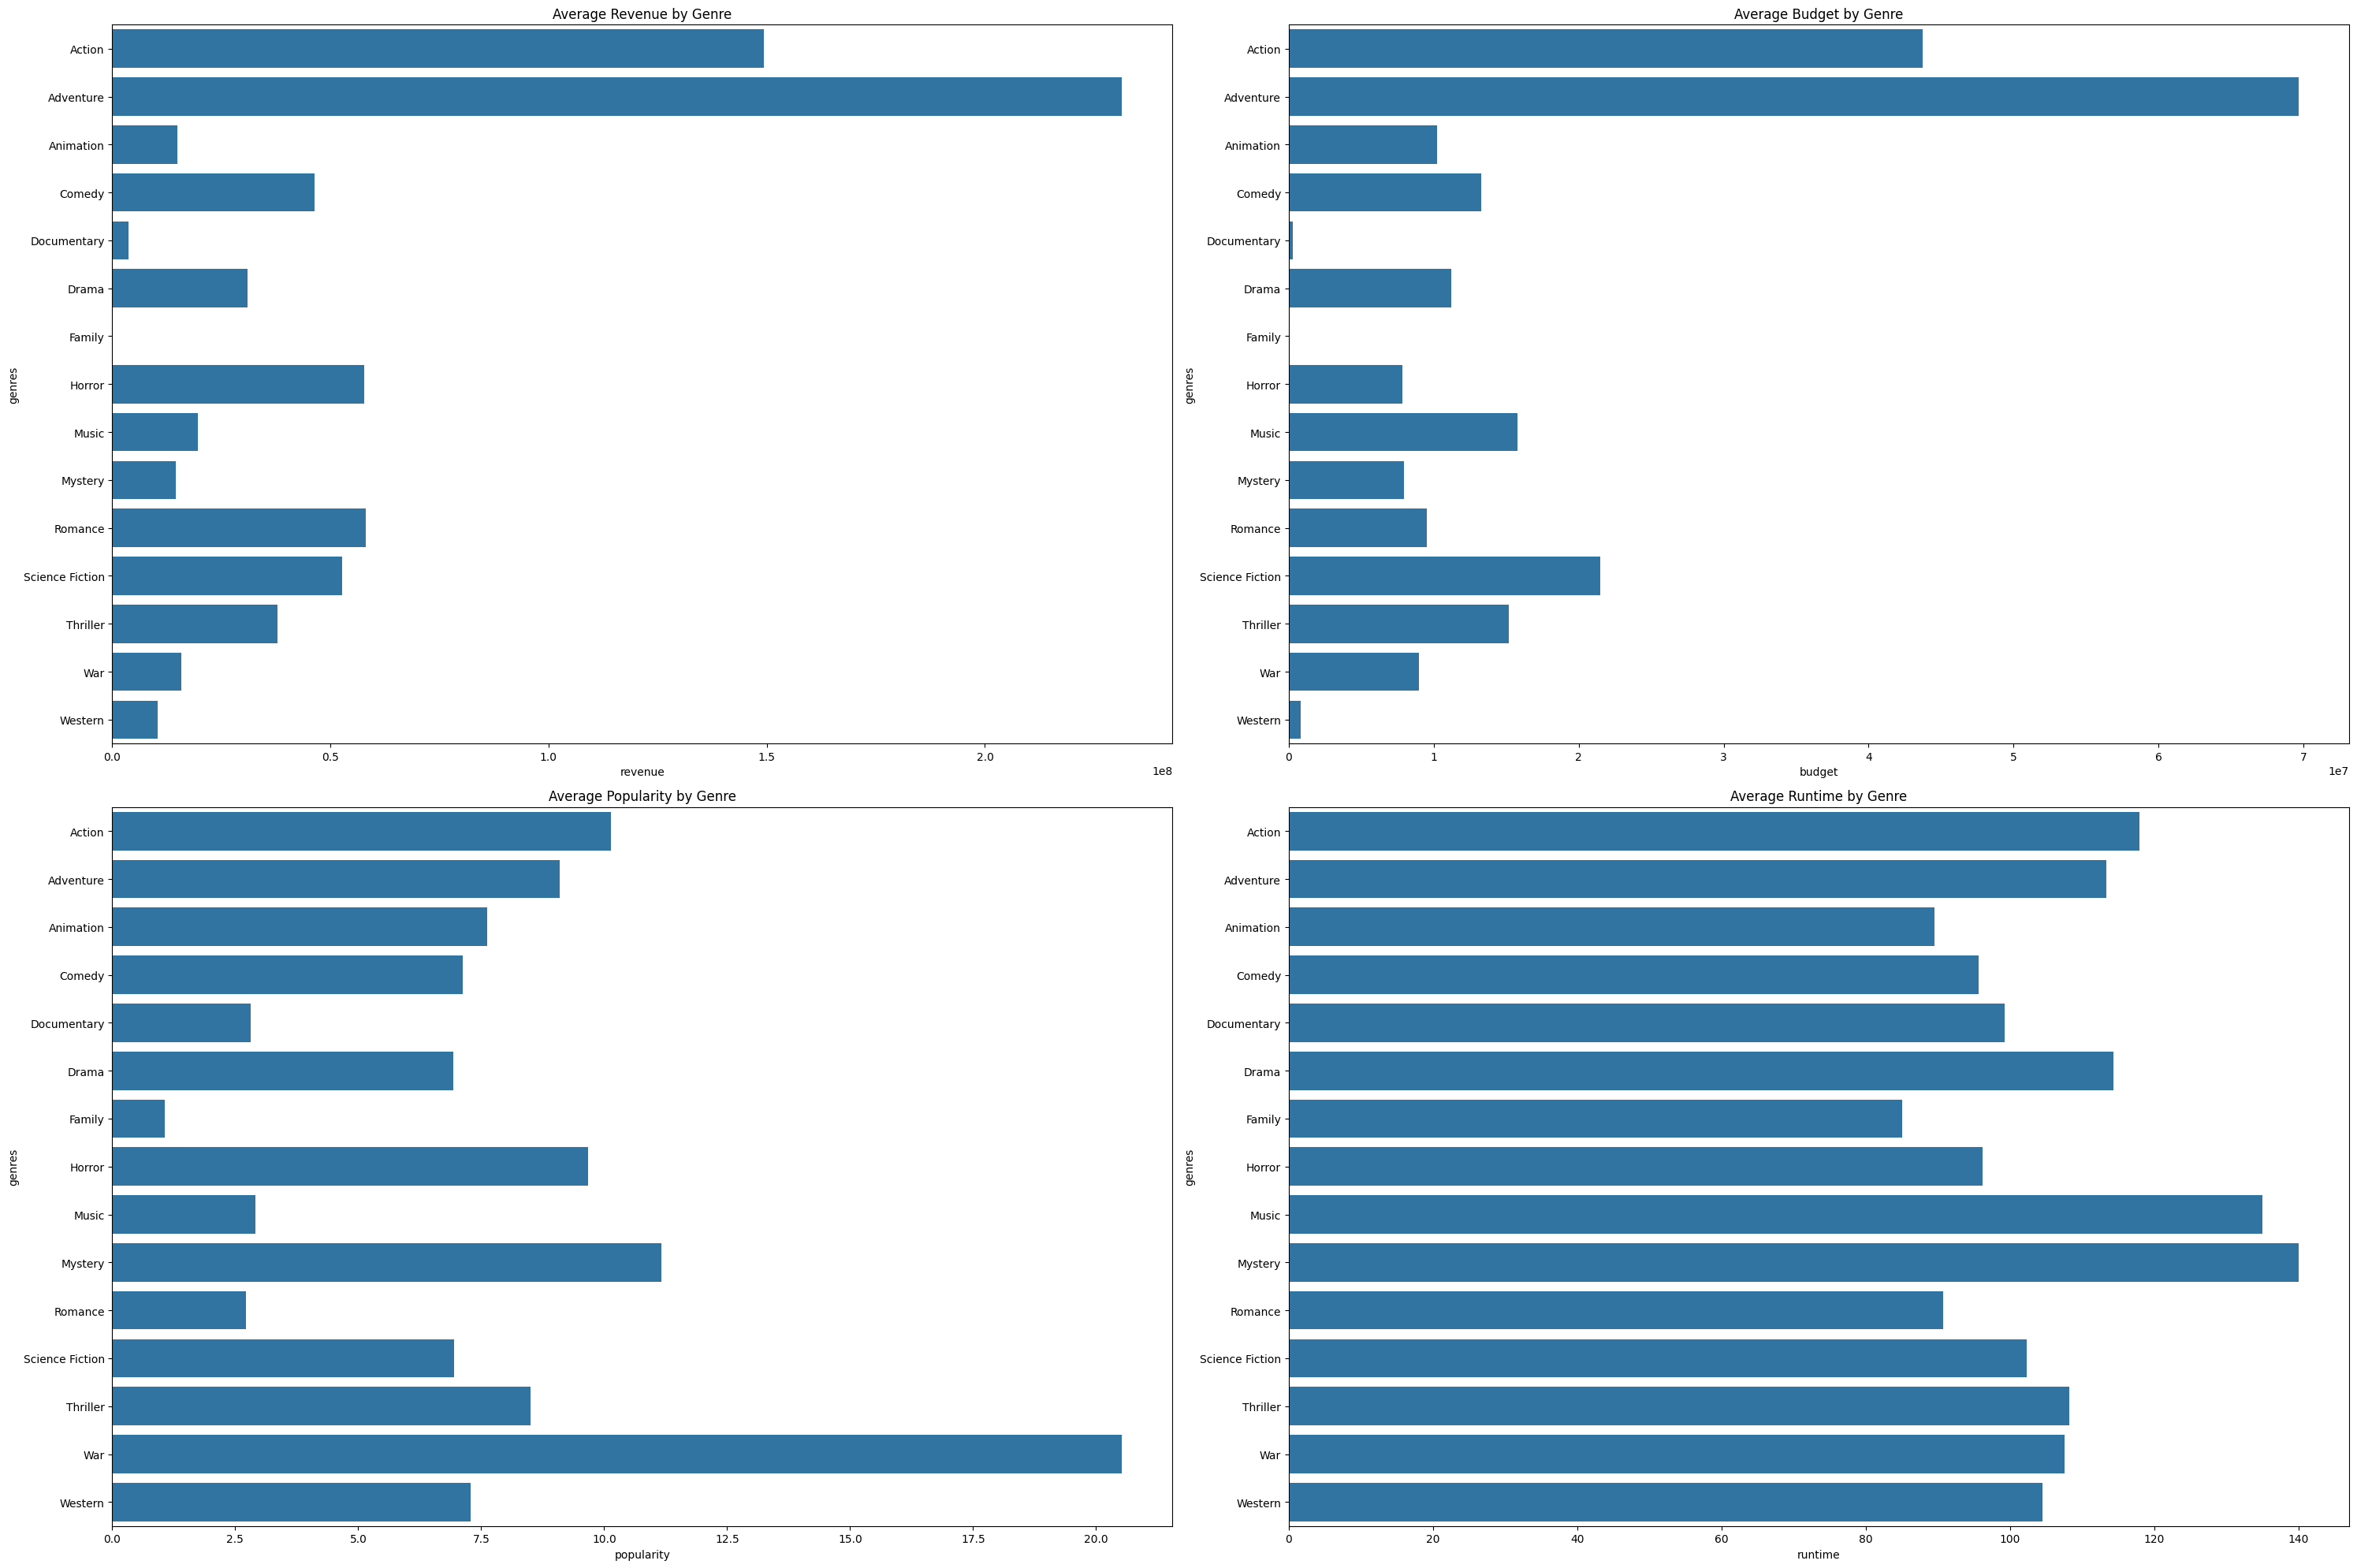

In [26]:
genres=train.loc[train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(30, 20))

plt.subplot(2, 2, 1)
sns.barplot(x=genres['revenue'], y=genres.index, orient='h')
plt.title('Average Revenue by Genre')

plt.subplot(2, 2, 2)
sns.barplot(x=genres['budget'], y=genres.index, orient='h')
plt.title('Average Budget by Genre')

plt.subplot(2, 2, 3)
sns.barplot(x=genres['popularity'], y=genres.index, orient='h')
plt.title('Average Popularity by Genre')

plt.subplot(2, 2, 4)
sns.barplot(x=genres['runtime'], y=genres.index, orient='h')
plt.title('Average Runtime by Genre')

plt.tight_layout()
plt.show()

I analyzed movie data to explore average revenue, budget, popularity, and runtime based on single-genre categorization. I filtered the dataset to include only movies categorized under a single genre, then grouped these movies by genre to compute the mean values for revenue, budget, popularity, and runtime. The results were visualized using bar plots to identify trends: Adventure movies showed the highest average revenue and budget, while Science Fiction and Action genres emerged as the most popular. I also found that Science Fiction movies tended to have longer runtimes compared to Adventure and Action films. This approach aimed to uncover genre-specific insights and trends across these key metrics.

In [27]:
cast=train['cast'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in cast for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [34]:
def prepare_data(df):
    # Calculate ratios
    df['_budget_runtime_ratio'] = (df['budget'] / df['runtime']).replace([np.inf, -np.inf, np.nan], 0)
    df['_budget_popularity_ratio'] = df['budget'] / df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0) / (df['release_year'] * df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_year']

    # Log transform budget
    df['budget'] = np.log1p(df['budget'])

    # Extract collection name or mark as 0 if no collection
    df['collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage'] = df['homepage'].isnull().astype(int)

    # Label encode collection names and original languages
    le = LabelEncoder()
    df['collection_name'] = le.fit_transform(df['collection_name'].fillna('').astype(str))
    df['original_language'] = le.fit_transform(df['original_language'].fillna('').astype(str))

    # Count number of Keywords and cast members
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)

    # Binary flags for presence of collection and tagline
    df['isbelongto_coll'] = df['belongs_to_collection'].isnull().astype(int)
    df['isTaglineNA'] = df['tagline'].isnull().astype(int)
    df['isOriginalLanguageEng'] = (df['original_language'] == 'en').astype(int)

    # Binary flag for movie release status
    df['ismovie_released'] = (df['status'] == 'Released').astype(int)

    # Count spoken languages
    df['no_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x))

    # Compute title and overview characteristics
    df['original_title_letter_count'] = df['original_title'].str.len()
    df['original_title_word_count'] = df['original_title'].str.split().str.len()
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()

    # Extract collection ID and count production details
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x: x[0]['id'] if len(x) > 0 else np.nan)
    df['production_countries_count'] = df['production_countries'].apply(lambda x: len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x: len(x))
    df['cast_count'] = df['cast'].apply(lambda x: len(x))
    df['crew_count'] = df['crew'].apply(lambda x: len(x))

    # Count crew member genders
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 1))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

    # One-hot encode categorical columns
    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies']:
        df[col] = df[col].apply(lambda x: sorted(list(set([n if n in train_dict[col] else col + '_etc' for n in [d['name'] for d in x]])))).apply(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1)

    df.drop(['genres_etc'], axis=1, inplace=True)

    # Normalize selected columns
    cols_to_normalize = [
        'runtime', 'popularity', 'budget', '_budget_runtime_ratio', '_budget_year_ratio',
        '_budget_popularity_ratio', '_releaseYear_popularity_ratio', '_releaseYear_popularity_ratio2',
        '_num_Keywords', '_num_cast', 'no_spoken_languages', 'original_title_letter_count',
        'original_title_word_count', 'title_word_count', 'overview_word_count', 'tagline_word_count',
        'production_countries_count', 'production_companies_count', 'cast_count', 'crew_count',
        'genders_0_crew', 'genders_1_crew', 'genders_2_crew'
    ]
    for col in cols_to_normalize:
        df[col] = normalize(df[[col]], axis=0).ravel()

    # Drop unnecessary columns
    df.drop([
        'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'overview', 'id',
        'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages',
        'status', 'title', 'Keywords', 'cast', 'crew', 'original_language', 'original_title', 'tagline',
        'collection_id'
    ], axis=1, inplace=True)

    # Fill remaining NaN values
    df.fillna(value=0.0, inplace=True)

    return df

# Function to get JSON data from dataframe
def get_json(df):
    result = {}
    for col in dict_columns:
        d = {}
        rows = df[col].values
        for row in rows:
            if row is None:
                continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']] = 0
                else:
                    d[i['name']] += 1
        result[col] = d
    return result

# Example dictionary columns
dict_columns = ['genres', 'production_countries', 'spoken_languages', 'production_companies']

# Example train and test datasets
train = pd.DataFrame()  # Your train dataframe
test = pd.DataFrame()  # Your test dataframe

# Function to clean dictionary columns
def clean_dict_columns(train_dict, test_dict):
    for col in dict_columns:
        remove = []
        train_id = set(list(train_dict[col].keys()))
        test_id = set(list(test_dict[col].keys()))

        remove += list(train_id - test_id) + list(test_id - train_id)
        for i in train_id.union(test_id) - set(remove):
            if train_dict[col][i] < 10 or i == '':
                remove += [i]
        for i in remove:
            if i in train_dict[col]:
                del train_dict[col][i]
            if i in test_dict[col]:
                del test_dict[col][i]

# Get JSON data for train and test datasets
train_dict = get_json(train)
test_dict = get_json(test)

# Clean dictionary columns in train and test dictionaries
clean_dict_columns(train_dict, test_dict)

# Concatenate train and test datasets and preprocess data
test['revenue'] = np.nan
all_data = prepare_data(pd.concat([train, test])).reset_index(drop=True)
train = all_data.loc[:train.shape[0]-1, :]
test = all_data.loc[train.shape[0]:, :]

print(train.shape)  # Check the shape of the training dataset

train.drop('revenue', axis=1, inplace=True)  # Drop revenue column from train dataset

train.head()  # Display first few rows of processed train dataset


KeyError: 'genres'